In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install statsmodels

import statsmodels

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col = 'Month', parse_dates = True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


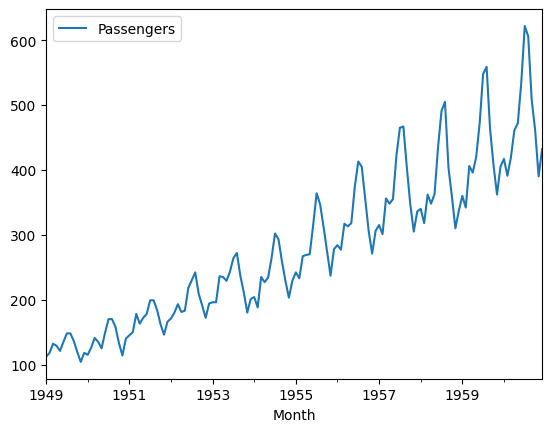

In [7]:
df.plot();

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [9]:
alpha = 0.2

In [10]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust = False).mean()

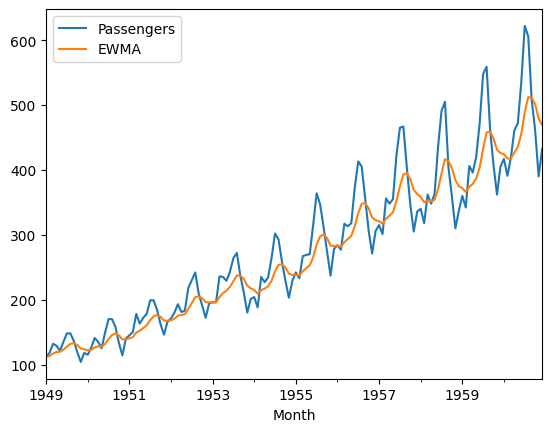

In [11]:
df.plot();

In [12]:
manual_ewma = []

for x in df['Passengers'].to_numpy():
  if len(manual_ewma)>0:
    xhat =  alpha * x + (1-alpha)*manual_ewma[-1]
  else:
    xhat = x

  manual_ewma.append(xhat)

df['Manual_EWMA'] = manual_ewma


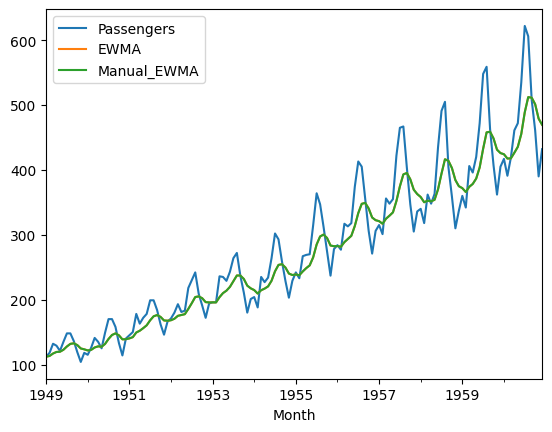

In [13]:
df.plot();

In [14]:
df.drop('Manual_EWMA', axis = 1, inplace = True)

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [16]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [18]:
df.index_freq = 'MS'

In [19]:
ses = SimpleExpSmoothing(df['Passengers'],
                         initialization_method='legacy-heuristic')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [20]:
res = ses.fit(smoothing_level = alpha, optimized = False)

In [21]:
res

In [22]:
df['SES'] = res.predict(start = df.index[0], end = df.index[-1])

In [23]:
np.allclose(df['SES'], res.fittedvalues)

True

<Axes: xlabel='Month'>

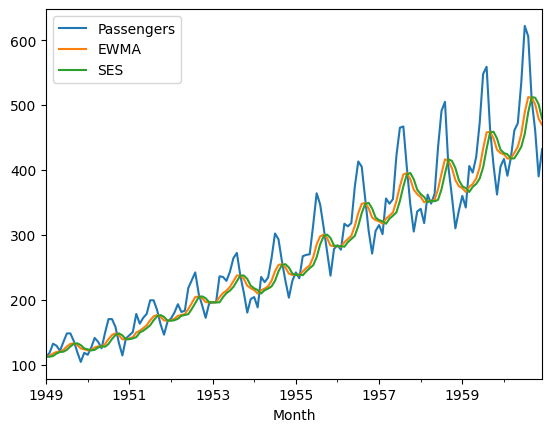

In [24]:
df.plot()

In [25]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [26]:
ses = SimpleExpSmoothing(df['Passengers'],
                         initialization_method= 'legacy-heuristic')

res = ses.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [27]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [28]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(Ntest)

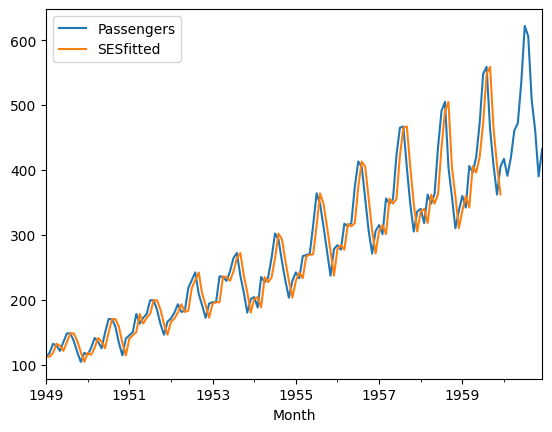

In [29]:
df[['Passengers', 'SESfitted']].plot();